# Developer notes and examples for `nelpy`

Here we will look at some common patterns and conventions to follow during the development of nelpy.

Let's start with the required imports.

In [1]:
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import nelpy as nel  # recommended import for nelpy
import nelpy.plotting as npl  # recommended import for the nelpy plotting library

%matplotlib inline

## Selective suppression of warnings

In general warnings should not all be supressed. They are usually useful, and sometimes critical in order to make sure that you get the expected behavior from nelpy. Sometimes, however, it is best to suppress warnings. Consider the following example.

In [2]:
epocharray = nel.EpochArray([[3,4],[5,8],[10,12], [16,20], [22,23]])
data = [3,4,2,5,2]

for epoch in epocharray:
    print(epoch)

<EpochArray: 1 epoch> totaling 1 seconds
<EpochArray: 1 epoch> totaling 3 seconds
<EpochArray: 1 epoch> totaling 2 seconds
<EpochArray: 1 epoch> totaling 4 seconds
<EpochArray: 1 epoch> totaling 1 seconds


C:\Users\etien\Anaconda3\lib\site-packages\nelpy\objects.py:241: UserWarning: No sampling frequency has been specified!
  warnings.warn("No sampling frequency has been specified!")
C:\Users\etien\Anaconda3\lib\site-packages\nelpy\objects.py:230: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


We see that we can easily iterate over all the epochs in `epocharray`, but we also get two warnings as a result, namely that no sampling frequency has been specified, and that no meta data has been set. These are useful warnings when constructing an (important or critical) EpochArray object, but not when we simply want to iterate over the epochs, or for example, when we want to compute or plot something related to those epochs.

The implementation of nelpy.plotting.core.plot (or simply npl.plot) looks similar to this:

C:\Users\etien\Anaconda3\lib\site-packages\nelpy\objects.py:241: UserWarning: No sampling frequency has been specified!
  warnings.warn("No sampling frequency has been specified!")
C:\Users\etien\Anaconda3\lib\site-packages\nelpy\objects.py:230: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


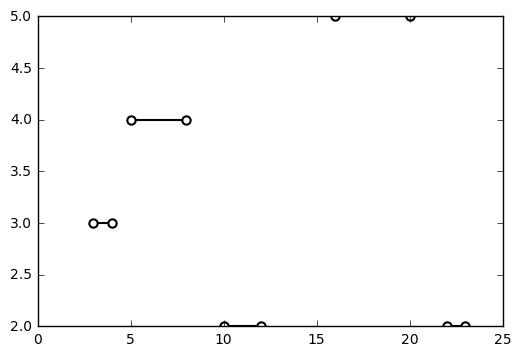

In [3]:
for epoch, val in zip(epocharray, data):
    plt.plot([epoch.start, epoch.stop], [val, val], '-o', color='k', markerfacecolor='w', lw=1.5, mew=1.5)

But again, we notice those warnings showing up. When plotting this type of figure, we do not need to warn the user about not having access to meta data, or not having an explicitly set sampling rate. Those warnings should have been dealt with when the actual data objects were created. So for thos plotting code, we wrap it in an ignore-warnings piece of code like this:

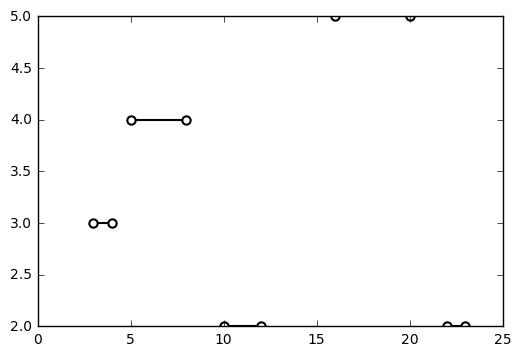

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  
    for epoch, val in zip(epocharray, data):
        plt.plot([epoch.start, epoch.stop], [val, val], '-o', color='k', markerfacecolor='w', lw=1.5, mew=1.5)

and we see that the warnings no longer show up.

Another use case for supressing warnings is if we want to have pretty (without warnings!) output for a jupyter notebook that we want to put online, for example. In that case, we can suppress all warnings simply by calling

In [5]:
warnings.simplefilter("ignore") 

after which no more warnings will show up during that session.

## Make use of default params and  `**kwargs` to maintain flexibility

We often need to assign default parameters, and ones that we personally think might look good. These can include colors, linewidths, text labels, axis limits, and more. However, we need to follow a strategy that will allow the user to customize these values as easily and flexibly as possible.

Consider again the `nelpy.plotting.core.plot` function, which has default behavior as follows:

    color: '0.3'  # gray
    linewidth (lw): 1.5
    markerfacecolor (mfc): white
    markeredgecolor (mec): same as color
    markeredgewidth (mew): same as linewidth
    
We can look at the default behavior below:

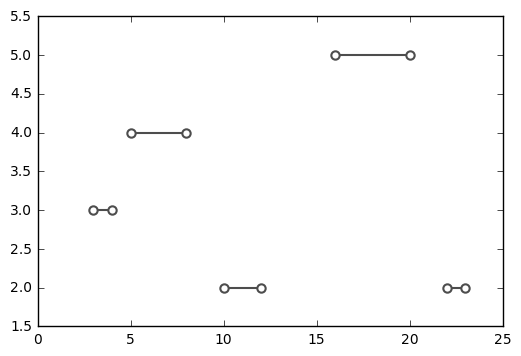

In [6]:
ax = npl.plot(epocharray, data, color='0.3')

But what if we want to change the linewidth, and say, the color? It would be annoying if we have to change both the `lw` and `mew` parameters just to change the linewidth, and similarly if we have to change both `color` and `ec` to change the color. So instead, we use default values to infer those as follows:

    if lw is None:
        lw = 1.5
    if mew is None:
        mew = lw
    if color is None:
        color = 'k'
    if mec is None:
        mec = ec
        
so that if only `lw` is specified, then `mew` automatically defaults to `lw`, and if only color is specified, then `mec` automatically defaults to `color`. This gives us a nice and clean interface.

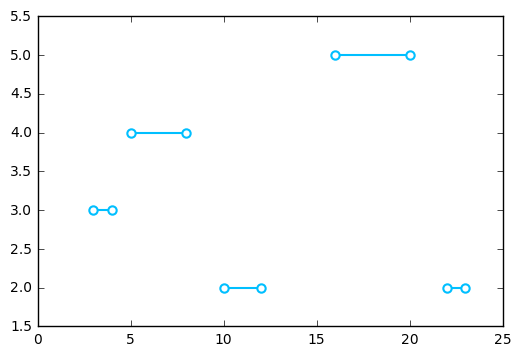

In [7]:
ax = npl.plot(epocharray, data, color='deepskyblue')

In the above, we see that simply specifying the `color` argument, we affect both the line color, and the marker color. However, we are free to customize both independently:

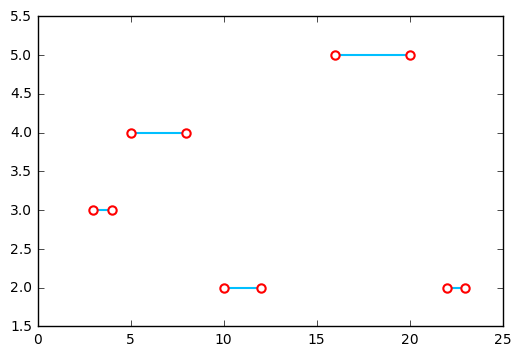

In [8]:
ax = npl.plot(epocharray, data, color='deepskyblue', mec='red')

and the same is true for the `linewidth` and `markeredgewidth` arguments.

However, it gets even better, because we can catch all of the other keywords that plt.plot might take, and pass those along. For example, the `ms` argument can be used to specify the marker size. We do not check for this keyword, nor do we have any logic dealing with it. We simply catch it in `**kwargs`, and pass it along to `plt.plot(**kwargs)`.

Then the user has the flexibility to change our custom plots whichever way she chooses, with the familiar interface of matplotlib.

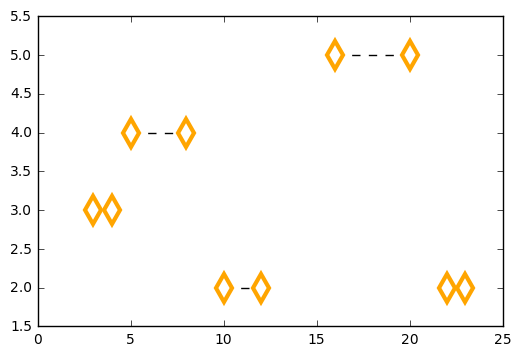

In [9]:
ax = npl.plot(epocharray, data, color='k', lw=1, marker='d', mew=3, mec='orange', ms=14, linestyle='dashed')

It is also best practice to not specify default parameters in the function definition, but rather to specify them as `arg=None` and then to describe the default values and / or behavior in the docstring, and to assign default values in the body of the function.

There are some caveats to this approach, such as when `None` is a legitimate and perhaps deliberate choice by the user. One example of such a case might be if the user wants to hide a particular element of a plot by setting the color to `None`, in which case it would be undesirable to overwrite the parameter value with the default. I have not really found an elegant way of dealing with this yet.

In our analysis scripts, we can also create dictionaries to pass to our functions, so that we don't need to re-write all of the parameters every time we call a function. For example,

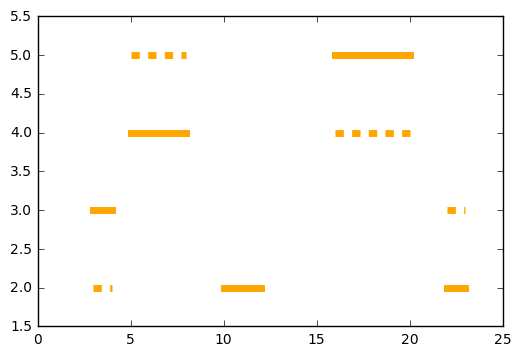

In [15]:
# create dictionary of frequently used parameters:
kws = {'lw': 5, 'ms':0, 'color': 'orange'}  # hide markers, set color to orange, and set linewidth to 5

# pass keyword dictionary to npl.plot():
ax = npl.plot(epocharray, data, **kws)
ax = npl.plot(epocharray, data[::-1], linestyle='dashed', **kws)